# Find distribution of local maxima in a Gaussian Random Field

In this notebook, I evaluate different known distributions for local maxima in a Gaussian Random Field.  I followed several steps to (a) look at the distribution through simulations, (b) apply different possible approaches to find the distribution.

It seems that none of these are applicable for local maxima without applying a filtering threshold.

# 1. Simulate random fields (without activation) and extract local maxima

In a first step, I 
- Simulate a guassian random field using nipype.  This field is huge (500x500x500) and therefore memory-intensive to ensure we have lots of local maxima.
- Look at the GRF.
- Export the GRF to a nifti file.  Before saving the data, I make sure all values are positive, because step (d) only extracts local maxima that are above 0.
- Extract all local maxima using nipype and fsl cluster.
- Look at the table of local maxima and print the total number of peaks.
- Look at the distribution of these maxima.

#### Import libraries 

In [1]:
% matplotlib inline
import os
import numpy as np
import nibabel as nib
from nipy.labs.utils.simul_multisubject_fmri_dataset import surrogate_3d_dataset
import nipy.algorithms.statistics.rft as rft
from __future__ import print_function, division
import math
import matplotlib.pyplot as plt
import palettable.colorbrewer as cb
from nipype.interfaces import fsl
import pandas as pd
import nipy.algorithms.statistics.intvol as intvol
from matplotlib import colors
import scipy.stats as stats
import seaborn as sns
from Facebook.utils.prog import log_progress as lp


#### Simulate RF

In [2]:
nsub = 40
smooth_FWHM = 6
smooth_sd = smooth_FWHM/(2*math.sqrt(2*math.log(2)))
data = surrogate_3d_dataset(n_subj=nsub,sk=smooth_sd,shape=(200,200,200),noise_level=1)

In [3]:
effects = np.arange(0,2,0.2)
effects

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8])

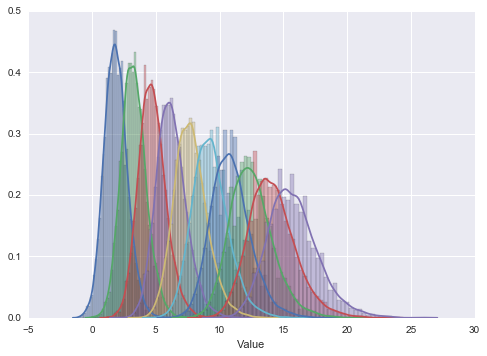

In [4]:
medians = []
means = []
skew = []
variance = []


for effect in lp(effects):
    datanew = data+effect

    Tmap = np.mean(datanew,axis=0)/np.sqrt(np.var(datanew,axis=0)/float(nsub))

    minimum = Tmap.min()
    newdata = Tmap - minimum #little trick because fsl.model.Cluster ignores negative values
    img=nib.Nifti1Image(newdata,np.eye(4))
    img.to_filename("files/RF.nii.gz")

    cl=fsl.model.Cluster()
    cl.inputs.threshold = 0
    cl.inputs.in_file="files/RF.nii.gz"
    cl.inputs.out_localmax_txt_file="files/locmax.txt"
    cl.inputs.num_maxima=1000000
    cl.inputs.connectivity=26
    cl.inputs.terminal_output='none'
    cl.run()
    
    peaks = pd.read_csv("files/locmax.txt",sep="\t").drop('Unnamed: 5',1)
    peaks.Value = peaks.Value + minimum
    means.append(np.mean(peaks.Value))
    medians.append(np.median(peaks.Value))
    skew.append(stats.skew(peaks.Value))
    variance.append(np.var(peaks.Value))
    sns.distplot(peaks.Value)


#### Run fsl cluster to extract local maxima

In [14]:
(means-means[0])/effects

/Users/Joke/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([        nan,  7.03436164,  7.14391203,  7.24472451,  7.34048577,
        7.42551891,  7.51928759,  7.59864999,  7.66636586,  7.7244428 ])

#### Read and print top of file with peaks ,  print total number of peaks.

In [16]:
np.sqrt(50)

7.0710678118654755

In [15]:
peaks.Value

0       5.91527
1       5.81527
2       5.41527
3       5.41527
4       5.31527
5       5.11527
6       5.11527
7       5.01527
8       5.01527
9       4.91527
10      4.91527
11      4.91527
12      4.81527
13      4.81527
14      4.81527
15      4.81527
16      4.81527
17      4.81527
18      4.81527
19      4.81527
20      4.71527
21      4.71527
22      4.71527
23      4.71527
24      4.71527
25      4.71527
26      4.71527
27      4.71527
28      4.71527
29      4.61527
         ...   
5607   -0.16473
5608   -0.16473
5609   -0.18473
5610   -0.20473
5611   -0.21473
5612   -0.25473
5613   -0.25473
5614   -0.25473
5615   -0.26473
5616   -0.28473
5617   -0.29473
5618   -0.30473
5619   -0.35473
5620   -0.35473
5621   -0.38473
5622   -0.40473
5623   -0.42473
5624   -0.42473
5625   -0.43473
5626   -0.43473
5627   -0.44473
5628   -0.48473
5629   -0.53473
5630   -0.59473
5631   -0.79473
5632   -0.85473
5633   -0.86473
5634   -0.96473
5635   -1.21473
5636   -1.67473
Name: Value, dtype: floa

#### Plot histogram local maxima

In [20]:
help(stats.norm.cdf)

Help on method cdf in module scipy.stats._distn_infrastructure:

cdf(self, x, *args, **kwds) method of scipy.stats._continuous_distns.norm_gen instance
    Cumulative distribution function of the given RV.
    
    Parameters
    ----------
    x : array_like
        quantiles
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    cdf : ndarray
        Cumulative distribution function evaluated at `x`



# 2. First approach: analytically derived distribution of local maxima above u 

#a. (Cheng & Schwartzman, 2015)
#b. RFT

[Cheng and Schwartzman](https://www.dropbox.com/s/goo6bj5vw82gd8b/Cheng%2C%20Schwartzman%20-%202015%20-%20Extremes%20-%20Distribution%20of%20the%20height%20of%20local%20maxima%20of%20Gaussian%20random%20fields.pdf?dl=0) recently published a paper in which they derive a distribution of local maxima over a certain threshold.  They make (like RFT) the assumption that the field is a GRF whose interior is non-empty... A consequence is that we can only compute this when the threshold is high enough to ensure there are only blobs and no holes.  We'll take a look how the theoretical distribution performs for lower thresholds.  This is their derived distribution:

For all local maxima above threshold $v$, extending $u$ above this threshold,

For each $t_0 \in T$ and each fixed $u>0$, as $v \rightarrow \infty$,

\begin{equation*}
F_t(u,v) = \frac{(u+v)^{N-1}e^{-(u+v)^2/2}}{v^{N-1}e^{-v^2/2}}
\end{equation*}

Below you can see that the approximation indeed only works well on very high thresholds, and therefore cannot be used to obtain the full distribution of all peaks.

We also compare with the random field theory approximation, with u the threshold:

\begin{equation}
F_t(u,t_0) = u e^{-u(t_0 - u)}
\end{equation}